In [2]:
import pandas as pd
import sklearn as sk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_regression
from sklearn.isotonic import IsotonicRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

In [3]:
# Load raw data
train_feat = pd.read_csv('train_features.csv')
train_sal = pd.read_csv('train_salaries.csv')
test_feat = pd.read_csv('test_features.csv')

# kiểm tra data
train_feat.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16


In [4]:
train_sal.head()


,jobId,salary
0,JOB1362684407687,130
1,JOB1362684407688,101
2,JOB1362684407689,137
3,JOB1362684407690,142
4,JOB1362684407691,163


In [5]:
test_feat.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis
0,JOB1362685407687,COMP33,MANAGER,HIGH_SCHOOL,NONE,HEALTH,22,73
1,JOB1362685407688,COMP13,JUNIOR,NONE,NONE,AUTO,20,47
2,JOB1362685407689,COMP10,CTO,MASTERS,BIOLOGY,HEALTH,17,9
3,JOB1362685407690,COMP21,MANAGER,HIGH_SCHOOL,NONE,OIL,14,96
4,JOB1362685407691,COMP36,JUNIOR,DOCTORAL,BIOLOGY,OIL,10,44


In [6]:
print(train_feat.shape)
print(train_sal.shape)
print(test_feat.shape)

(1000000, 8)
(1000000, 2)
(1000000, 8)


In [7]:
train_data = pd.merge(train_feat, train_sal, on ='jobId')

train_data.head()

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
0,JOB1362684407687,COMP37,CFO,MASTERS,MATH,HEALTH,10,83,130
1,JOB1362684407688,COMP19,CEO,HIGH_SCHOOL,NONE,WEB,3,73,101
2,JOB1362684407689,COMP52,VICE_PRESIDENT,DOCTORAL,PHYSICS,HEALTH,10,38,137
3,JOB1362684407690,COMP38,MANAGER,DOCTORAL,CHEMISTRY,AUTO,8,17,142
4,JOB1362684407691,COMP7,VICE_PRESIDENT,BACHELORS,PHYSICS,FINANCE,8,16,163


In [8]:
train_data.shape

(1000000, 9)

In [9]:
# Check for missing data(kiểm tra dữ liệu có bị thiếu không )
missing_data = train_data.isnull().sum()
missing_data

jobId                  0
companyId              0
jobType                0
degree                 0
major                  0
industry               0
yearsExperience        0
milesFromMetropolis    0
salary                 0
dtype: int64

In [10]:
# Check for invalid salaries (kiểm tra xem có lương =0 không ?)
zero_salary = train_data['salary']<=0
invalid_salary = train_data[zero_salary]

invalid_salary

,jobId,companyId,jobType,degree,major,industry,yearsExperience,milesFromMetropolis,salary
30559,JOB1362684438246,COMP44,JUNIOR,DOCTORAL,MATH,AUTO,11,7,0
495984,JOB1362684903671,COMP34,JUNIOR,NONE,NONE,OIL,1,25,0
652076,JOB1362685059763,COMP25,CTO,HIGH_SCHOOL,NONE,AUTO,6,60,0
816129,JOB1362685223816,COMP42,MANAGER,DOCTORAL,ENGINEERING,FINANCE,18,6,0
828156,JOB1362685235843,COMP40,VICE_PRESIDENT,MASTERS,ENGINEERING,WEB,3,29,0


In [11]:
# Define categorical variables
train_data['jobId']=pd.Categorical(train_data['jobId'])
train_data['companyId']=pd.Categorical(train_data['companyId'])
train_data['jobType']=pd.Categorical(train_data['jobType'])
train_data['degree']=pd.Categorical(train_data['degree'])
train_data['major']=pd.Categorical(train_data['major'])
train_data['industry']=pd.Categorical(train_data['industry'])
train_data.dtypes

jobId                  category
companyId              category
jobType                category
degree                 category
major                  category
industry               category
yearsExperience           int64
milesFromMetropolis       int64
salary                    int64
dtype: object

In [12]:
# Thống kê dữ liệu
train_data.describe()

,yearsExperience,milesFromMetropolis,salary
count,1000000.000000,1000000.000000,1000000.000000
mean,11.992386,49.529260,116.061818
std,7.212391,28.877733,38.717936
min,0.000000,0.000000,0.000000
25%,6.000000,25.000000,88.000000
50%,12.000000,50.000000,114.000000
75%,18.000000,75.000000,141.000000
max,24.000000,99.000000,301.000000


In [13]:
# Unique values in train_data
train_data.nunique()

jobId                  1000000
companyId                   63
jobType                      8
degree                       5
major                        9
industry                     7
yearsExperience             25
milesFromMetropolis        100
salary                     280
dtype: int64

In [14]:
# xác định hệ số tương quan của dữ liệu 
train_data.corr()

,yearsExperience,milesFromMetropolis,salary
yearsExperience,1.000000,0.000673,0.375013
milesFromMetropolis,0.000673,1.000000,-0.297666
salary,0.375013,-0.297666,1.000000


In [15]:
# ????

In [16]:
# Thiết lập lại dữ liệu vì ID công việc và ID công ty sẽ không ảnh hưởng đến lương nên loại bỏ bớt 

In [17]:
# xóa đi các trường không cần thiết 
train_data = train_data.drop('jobId', axis = 1)
train_data = train_data.drop('companyId', axis = 1)
test_feat = test_feat.drop('jobId', axis = 1)
test_feat = test_feat.drop('companyId', axis = 1)

In [18]:
#One hot encode categorical data in the dataset
train_data = pd.get_dummies(train_data)
train_data.head()

,yearsExperience,milesFromMetropolis,salary,jobType_CEO,jobType_CFO,jobType_CTO,jobType_JANITOR,jobType_JUNIOR,jobType_MANAGER,jobType_SENIOR,...,major_MATH,major_NONE,major_PHYSICS,industry_AUTO,industry_EDUCATION,industry_FINANCE,industry_HEALTH,industry_OIL,industry_SERVICE,industry_WEB
0,10,83,130,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
1,3,73,101,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
2,10,38,137,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
3,8,17,142,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
4,8,16,163,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,0


In [1]:
# Sự tương quan giữa tất cả các tính năng khác nhau sẽ được trình bày bằng ma trận

# plt.subplots(figsize = (40, 30))
# sns.heatmap(train_data.corr(), cmap = 'BuGn', linewidth = 0.005, annot = True)

In [20]:
# Rất rõ ràng rằng Kinh nghiệm (Năm) có mối tương quan cao nhất với Mức lương.
# Các vai trò công việc khác như của CFO, CTO và CEO cũng cho thấy mối tương quan cao với Mức lương. 
# Bằng cấp Doctorol có tương quan với mức lương cao hơn

In [21]:
x = train_data.drop('salary', axis = 1)
    
y = train_data['salary']

In [22]:
# chia data để train và test tỷ lệ 80:20

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=True)

print("Số lượng mẫu đào tạo:",x_train.shape[0])
print("Số lượng mẫu test :", x_test.shape[0])

Số lượng mẫu đào tạo: 800000
Số lượng mẫu test : 200000


In [23]:
# sử dụng thuật toán hồi quy tuyến tính

In [24]:
# tạo đối tượng Linear Regressor
lr = LinearRegression()

lr.fit(x_train, y_train)
print(lr)
# đưa ra dự đoán cho 5 mức lương đầu tiên
y_hat = lr.predict(x_test)
print("5 mức lương đầu tiên là : ", y_hat[0:5])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
5 mức lương đầu tiên là :  [ 65.890625   152.92129517 130.9079895  107.78588867 113.09985352]


In [25]:
# Linear function:$$ Yhat = a + b x
print("b: ", lr.coef_)
print("a: ", lr.intercept_)

b:  [ 2.00895828e+00 -4.00066860e-01  1.50185244e+11  1.50185244e+11
  1.50185244e+11  1.50185244e+11  1.50185244e+11  1.50185244e+11
  1.50185244e+11  1.50185244e+11 -2.02638489e+10 -2.02638489e+10
 -2.02638489e+10 -2.02638489e+10 -2.02638489e+10 -2.03533099e+10
 -2.03533099e+10 -2.03533099e+10 -2.03533099e+10 -2.03533099e+10
 -2.03533099e+10 -2.03533099e+10 -2.03533099e+10 -2.03533099e+10
  3.89286669e+10  3.89286669e+10  3.89286669e+10  3.89286669e+10
  3.89286669e+10  3.89286669e+10  3.89286669e+10]
a:  -148496751768.4715


In [26]:
# kiểm tra thử
y_hat=lr.predict(x_test) 
y_hat

array([ 65.890625  , 152.92129517, 130.9079895 , ..., 112.82815552,
        56.73425293, 128.84353638])

In [27]:
#kiểm tra độ chính xác 
print('The R-square is: ', lr.score(x,y))

The R-square is:  0.7435332993594033


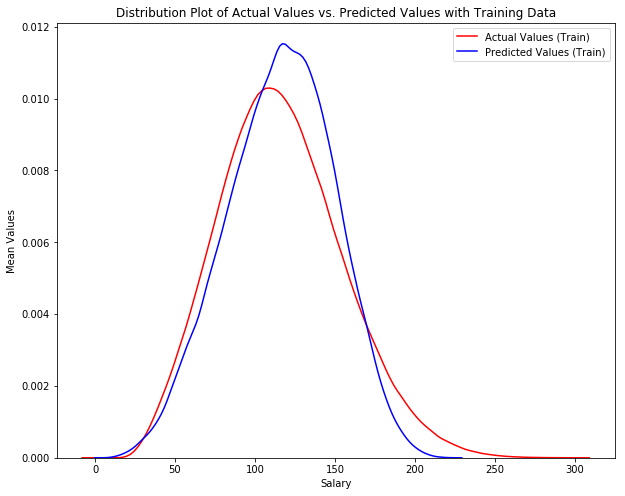

In [28]:
def DistributionPlot(RedFunction, BlueFunction, RedName, BlueName, Title):
    width = 10
    height = 8
    plt.figure(figsize=(width, height))

    ax1 = sns.distplot(RedFunction, hist=False, color="r", label=RedName)
    ax2 = sns.distplot(BlueFunction, hist=False, color="b", label=BlueName, ax=ax1)

    plt.title(Title)
    plt.xlabel('Salary')
    plt.ylabel('Mean Values')
    plt.show()
    plt.close()

#Distribution plot for the 80% train data
Title = 'Distribution Plot of Actual Values vs. Predicted Values with Training Data'
DistributionPlot(y_train, y_hat, "Actual Values (Train)", "Predicted Values (Train)", Title)

In [29]:
# sử dụng Random forest Regressor Algorithm

In [30]:
# rf = RandomForestRegressor(n_estimators = 60, max_depth = 25, 
#                            min_samples_split = 20, n_jobs = 2, 
#                            max_features = 30)
rf = RandomForestRegressor(n_estimators=50,verbose=2,n_jobs=4,min_samples_split=30,random_state=3465343)
# print(rf)

In [31]:
rf.fit(x_train, y_train)
rf.score(x_test, y_test)

building tree 1 of 50building tree 2 of 50
building tree 3 of 50

building tree 4 of 50
building tree 5 of 50
building tree 6 of 50
building tree 7 of 50
building tree 8 of 50
building tree 9 of 50
building tree 10 of 50
building tree 11 of 50
building tree 12 of 50
building tree 13 of 50
building tree 14 of 50
building tree 15 of 50
building tree 16 of 50
building tree 17 of 50building tree 18 of 50

building tree 19 of 50
building tree 20 of 50
building tree 21 of 50
building tree 22 of 50
building tree 23 of 50
building tree 24 of 50
building tree 25 of 50
building tree 26 of 50
building tree 27 of 50
building tree 28 of 50
building tree 29 of 50building tree 30 of 50

building tree 31 of 50
building tree 32 of 50
building tree 33 of 50
building tree 34 of 50
building tree 35 of 50
building tree 36 of 50


[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:  1.1min


building tree 37 of 50
building tree 38 of 50
building tree 39 of 50
building tree 40 of 50
building tree 41 of 50
building tree 42 of 50
building tree 43 of 50
building tree 44 of 50
building tree 45 of 50
building tree 46 of 50
building tree 47 of 50
building tree 48 of 50
building tree 49 of 50
building tree 50 of 50


[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:  1.6min finished
[Parallel(n_jobs=4)]: Done  33 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    1.3s finished


0.7520569525629394

In [32]:
# Sử dụng Ridge Regressor Algorithm

In [33]:
p = PolynomialFeatures(2)

#Fitting object to training/testing data
x_train_p = p.fit_transform(x_train)
x_test_p = p.fit_transform(x_test)
print(p)

PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)


In [34]:
rg = Ridge(alpha = 1.0)
rg.fit(x_train_p, y_train)
rg.score(x_test_p, y_test)

0.7637768753882153

In [35]:
gbr = GradientBoostingRegressor(n_estimators=1000,max_depth=6,verbose=10)
gbr.fit(x_train,y_train)

      Iter       Train Loss   Remaining Time 
         1        1338.4662           77.12m
         2        1207.4288           74.32m
         3        1099.1323           73.06m
         4        1009.0657           71.96m
         5         933.1269           71.73m
         6         869.2338           71.43m
         7         814.3966           71.26m
         8         767.0616           70.87m
         9         725.2538           70.73m
        10         687.5010           70.85m
        11         654.9137           71.45m
        12         625.2223           71.72m
        13         599.4642           71.66m
        14         575.8019           72.25m
        15         555.5313           72.74m
        16         537.5653           72.85m
        17         521.0972           72.58m
        18         506.1106           72.79m
        19         492.0895           72.73m
        20         480.8976           72.67m
        21         471.1199           72.90m
        2

       183         352.1875           60.70m
       184         352.1718           60.59m
       185         352.1496           60.50m
       186         352.1208           60.42m
       187         352.1047           60.32m
       188         352.0834           60.27m
       189         352.0559           60.30m
       190         352.0312           60.29m
       191         352.0140           60.26m
       192         351.9937           60.25m
       193         351.9744           60.22m
       194         351.9569           60.16m
       195         351.9356           60.08m
       196         351.9132           60.04m
       197         351.8906           60.01m
       198         351.8718           60.02m
       199         351.8539           60.00m
       200         351.8323           59.92m
       201         351.8129           59.90m
       202         351.7976           59.92m
       203         351.7767           59.86m
       204         351.7563           59.85m
       205

       366         348.8612           50.44m
       367         348.8439           50.35m
       368         348.8264           50.31m
       369         348.8104           50.21m
       370         348.7916           50.14m
       371         348.7757           50.05m
       372         348.7601           49.98m
       373         348.7410           49.90m
       374         348.7266           49.83m
       375         348.7085           49.76m
       376         348.6948           49.69m
       377         348.6794           49.64m
       378         348.6646           49.56m
       379         348.6477           49.48m
       380         348.6299           49.38m
       381         348.6140           49.31m
       382         348.5974           49.24m
       383         348.5825           49.14m
       384         348.5694           49.07m
       385         348.5529           49.00m
       386         348.5415           48.91m
       387         348.5281           48.82m
       388

       549         346.2370           35.97m
       550         346.2245           35.90m
       551         346.2090           35.81m
       552         346.1976           35.74m
       553         346.1868           35.67m
       554         346.1748           35.60m
       555         346.1592           35.51m
       556         346.1462           35.42m
       557         346.1339           35.33m
       558         346.1220           35.26m
       559         346.1102           35.18m
       560         346.0981           35.11m
       561         346.0879           35.03m
       562         346.0765           34.94m
       563         346.0626           34.85m
       564         346.0515           34.77m
       565         346.0393           34.69m
       566         346.0241           34.61m
       567         346.0104           34.53m
       568         345.9984           34.45m
       569         345.9837           34.37m
       570         345.9709           34.30m
       571

       732         343.9988           21.29m
       733         343.9865           21.22m
       734         343.9780           21.15m
       735         343.9677           21.07m
       736         343.9587           21.00m
       737         343.9458           20.92m
       738         343.9372           20.84m
       739         343.9238           20.76m
       740         343.9113           20.68m
       741         343.9038           20.61m
       742         343.8927           20.53m
       743         343.8820           20.45m
       744         343.8737           20.37m
       745         343.8639           20.29m
       746         343.8539           20.21m
       747         343.8397           20.13m
       748         343.8271           20.05m
       749         343.8127           19.97m
       750         343.7987           19.89m
       751         343.7835           19.81m
       752         343.7701           19.73m
       753         343.7624           19.65m
       754

       915         341.9577            6.87m
       916         341.9490            6.79m
       917         341.9438            6.71m
       918         341.9353            6.63m
       919         341.9188            6.55m
       920         341.9080            6.47m
       921         341.8927            6.39m
       922         341.8799            6.31m
       923         341.8650            6.23m
       924         341.8544            6.15m
       925         341.8450            6.07m
       926         341.8349            5.99m
       927         341.8248            5.91m
       928         341.8174            5.83m
       929         341.8069            5.75m
       930         341.7925            5.67m
       931         341.7797            5.59m
       932         341.7691            5.51m
       933         341.7596            5.43m
       934         341.7488            5.35m
       935         341.7388            5.27m
       936         341.7279            5.19m
       937

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=6, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=1000, presort='auto', random_state=None,
             subsample=1.0, verbose=10, warm_start=False)

In [36]:
gbr.score(x_test,y_test)

0.7613131475247594

In [42]:
# print(y_train)

In [38]:
# x_train_1, x_test_1, y_train_1, y_test_1 = make_regression(n_samples=10, n_features=1, random_state=41)
# iso_reg = IsotonicRegression().fit(x_train, y_train)


In [39]:
#iso_reg.score(x_test,y_test)

In [40]:
clf = MLPRegressor(random_state=1, max_iter=500)
clf.fit(x_train, y_train)

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=500, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [41]:
clf.score(x_test,y_test)

0.7634983860672175